In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import warnings
import sys
from urllib.parse import urlparse
import mlflow

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


In [2]:
BASE_DIR = r"C:\Users\Navnit Ashok Nair\OneDrive\Desktop\gyan data\part4"

In [3]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    if (temp[1]==''):
        gender=0
    else:
        gender = int(temp[1])
    image_paths.append(image_path)
    gender_labels.append(gender)

  0%|          | 0/11977 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame()
df['image'], df['gender'] = image_paths,gender_labels
df.head()

,image,gender
0,C:\Users\Navnit Ashok Nair\OneDrive\Desktop\gy...,0
1,C:\Users\Navnit Ashok Nair\OneDrive\Desktop\gy...,0
2,C:\Users\Navnit Ashok Nair\OneDrive\Desktop\gy...,1
3,C:\Users\Navnit Ashok Nair\OneDrive\Desktop\gy...,1
4,C:\Users\Navnit Ashok Nair\OneDrive\Desktop\gy...,1


In [5]:
df.groupby('gender').count()

,image
gender,
0,6066
1,5911


In [6]:
gender_dict = {0:'Male', 1:'Female'}

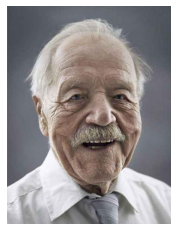

In [7]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);


<AxesSubplot:xlabel='gender', ylabel='count'>

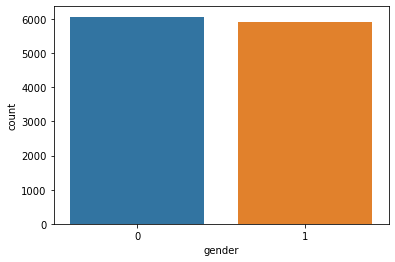

In [8]:
sns.countplot(df['gender'])

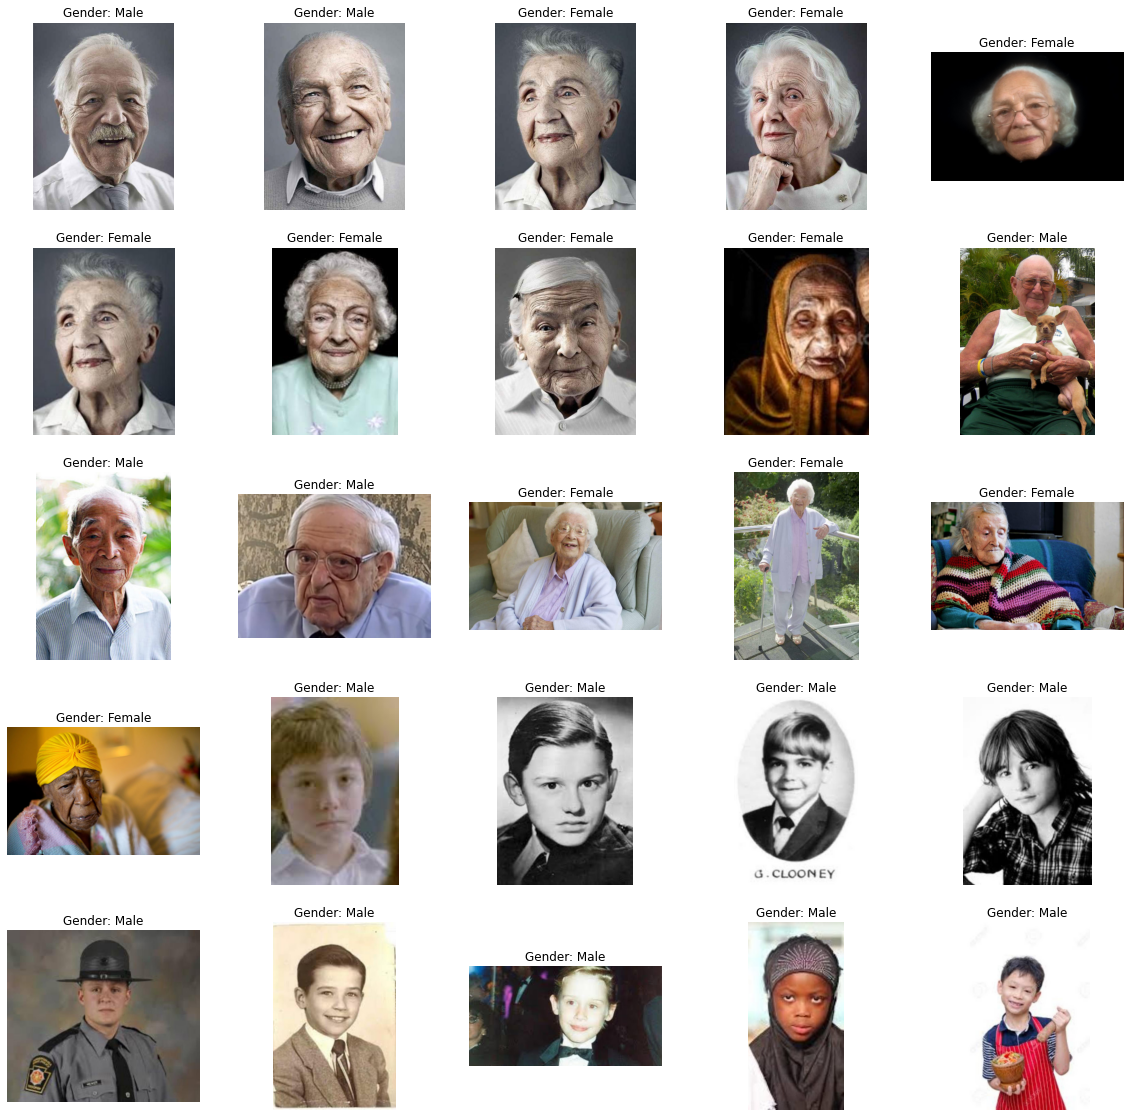

In [9]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file,gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Gender: {gender_dict[gender]}")
    plt.axis('off')


In [10]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [11]:
X = extract_features(df['image'])

  0%|          | 0/11977 [00:00<?, ?it/s]

In [12]:
X.shape

(11977, 128, 128, 1)

In [13]:
# normalize the images
X = X/255.0

In [14]:
y_gender = np.array(df['gender'])

In [15]:
input_shape = (128, 128, 1)


In [16]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(16, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(32, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(32, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
#conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
#maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_3)

# fully connected layers
dense_1 = Dense(32, activation='relu') (flatten)
#dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.6) (dense_1)
#dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)

model = Model(inputs=[inputs], outputs=[output_1])

model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [25]:
#alpha = float(sys.argv[1]) if len(sys.argv) > 1 else 1
with mlflow.start_run():
    # train model
    history = model.fit(x=X, y=y_gender,steps_per_epoch=70, batch_size=32, epochs=30, validation_split=0.2)
    image_index = 1000
    print("image index:", image_index)
    print("Original Gender:", gender_dict[y_gender[image_index]])
    # predict from model
    pred = model.predict(X[image_index].reshape(1, 128, 128, 1))

    pred_gender = gender_dict[round(pred[0][0])]
    print("Predicted Gender:", pred_gender)
    #plt.axis('off')
    #plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
    mlflow.log_param("image index", image_index)
    mlflow.log_param("orginal_gender",gender_dict[y_gender[image_index]])
    mlflow.log_param("predicted_gender",pred_gender)
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    # Model registry does not work with file store
    if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(model, "model", registered_model_name="ElasticnetWineModel")
    else:
        mlflow.sklearn.log_model(model, "model")

Epoch 1/30
70/70 [==============================] - 23s 326ms/step - loss: 0.4047 - accuracy: 0.8192 - val_loss: 0.6046 - val_accuracy: 0.6757
Epoch 2/30
70/70 [==============================] - 17s 243ms/step - loss: 0.3945 - accuracy: 0.8121 - val_loss: 0.5425 - val_accuracy: 0.7362
Epoch 3/30
70/70 [==============================] - 17s 236ms/step - loss: 0.3894 - accuracy: 0.8165 - val_loss: 0.5663 - val_accuracy: 0.7116
Epoch 4/30
70/70 [==============================] - 16s 232ms/step - loss: 0.3897 - accuracy: 0.8170 - val_loss: 0.5374 - val_accuracy: 0.7358
Epoch 5/30
70/70 [==============================] - 17s 239ms/step - loss: 0.3548 - accuracy: 0.8357 - val_loss: 0.5567 - val_accuracy: 0.7504
Epoch 6/30
70/70 [==============================] - 16s 234ms/step - loss: 0.3679 - accuracy: 0.8313 - val_loss: 0.6104 - val_accuracy: 0.6790
Epoch 7/30
70/70 [==============================] - 31s 449ms/step - loss: 0.3600 - accuracy: 0.8335 - val_loss: 0.5553 - val_accuracy: 0.7300